In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepcontractor/200k-short-texts-for-humor-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/200k-short-texts-for-humor-detection


In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

In [3]:
df = pd.read_csv('/kaggle/input/200k-short-texts-for-humor-detection/dataset.csv')
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [4]:
df.shape

(200000, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [6]:
df.apply(pd.isnull).sum()

text     0
humor    0
dtype: int64

In [7]:
df.duplicated().sum()

0

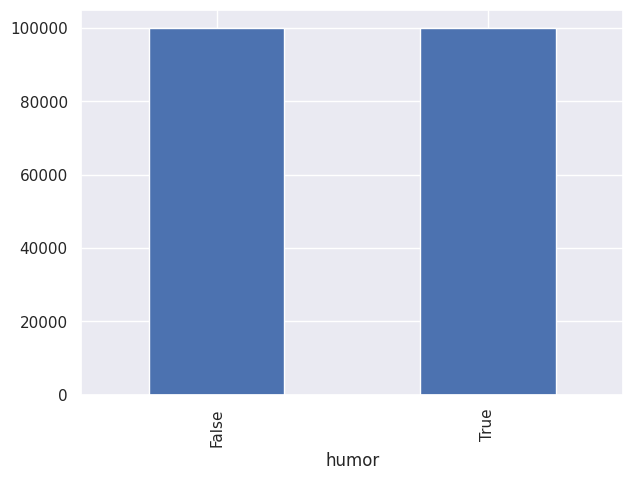

In [8]:
df['humor'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.show()

In [9]:
df['humor'].value_counts()

humor
False    100000
True     100000
Name: count, dtype: int64

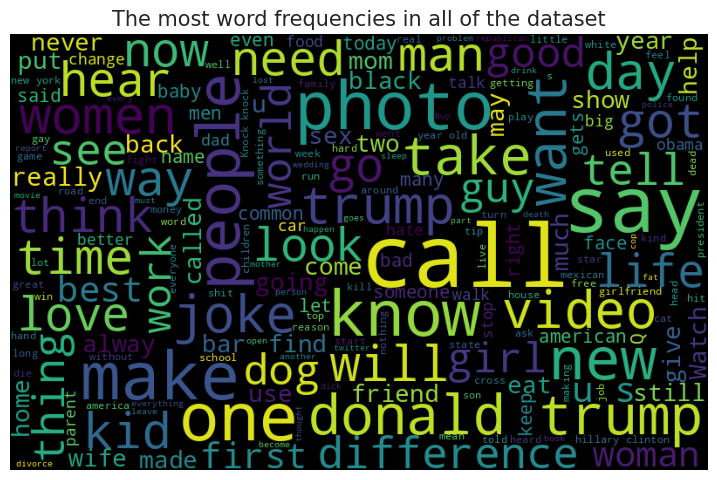

In [10]:
plt.figure(figsize = (9, 7))
all_sent = ' '.join([sentence for sentence in df['text']])
word_cloud_all = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 100).generate(all_sent)
plt.imshow(word_cloud_all)
plt.title('The most word frequencies in all of the dataset', fontsize = 15)
plt.axis('off')
plt.show()

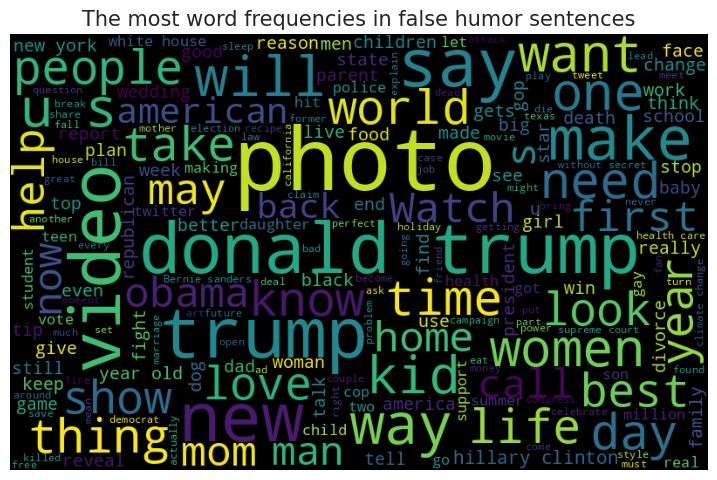

In [11]:
plt.figure(figsize = (9, 7))
false_sent = ' '.join([sentence for sentence in df['text'][df['humor'] == False]])
word_cloud_false = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(false_sent)
plt.imshow(word_cloud_false)
plt.title('The most word frequencies in false humor sentences', fontsize = 15)
plt.axis('off')
plt.show()

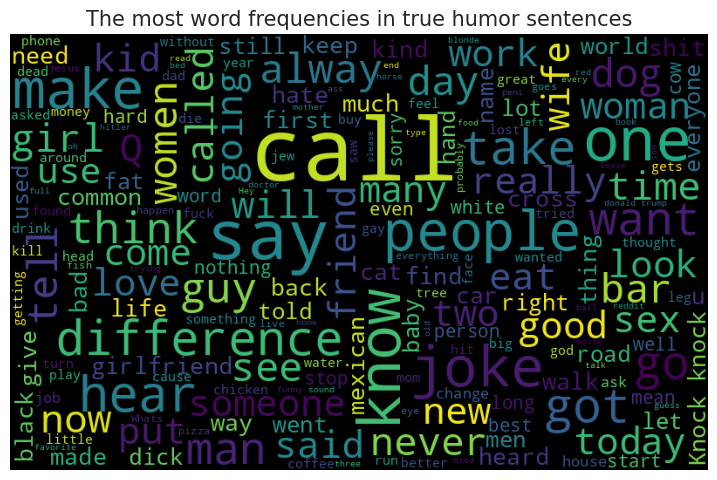

In [12]:
plt.figure(figsize = (9, 7))
true_sent = ' '.join([sentence for sentence in df['text'][df['humor'] == True]])
word_cloud_true = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(true_sent)
plt.imshow(word_cloud_true)
plt.title('The most word frequencies in true humor sentences', fontsize = 15)
plt.axis('off')
plt.show()

In [13]:
sw = stopwords.words('english')

In [14]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    return ' '.join(words)

In [15]:
df['cleaned_text'] = df['text'].apply(text_preprocessing)

In [16]:
df.head()

,text,humor,cleaned_text
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,joe biden rules bid guys running
1,Watch: darvish gave hitter whiplash with slow ...,False,watch darvish gave hitter whiplash slow pitch
2,What do you call a turtle without its shell? d...,True,call turtle without shell dead
3,5 reasons the 2016 election feels so personal,False,reasons election feels personal
4,"Pasco police shot mexican migrant from behind,...",False,pasco police shot mexican migrant behind new a...


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
seq = tokenizer.texts_to_sequences(df['cleaned_text'])

In [18]:
seq[:10]

[[780, 1561, 645, 3713, 178, 410],
 [95, 33985, 513, 10251, 20050, 1019, 3163],
 [3, 3027, 155, 3714, 99],
 [355, 237, 1598, 1184],
 [33986, 104, 396, 236, 5619, 318, 5, 7039, 182],
 [4300, 1480, 646, 15477, 81, 114, 201, 1870, 13622],
 [1173, 2087, 57, 150, 1847, 33987],
 [1840, 268, 135, 7618, 1225, 1066, 11677],
 [67, 275, 93, 2347, 6319, 10252, 5235],
 [116, 400, 6087, 4792]]

In [19]:
maxlen = max([len(i) for i in seq])
maxlen

16

In [20]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')
pad_seq

array([[  780,  1561,   645, ...,     0,     0,     0],
       [   95, 33985,   513, ...,     0,     0,     0],
       [    3,  3027,   155, ...,     0,     0,     0],
       ...,
       [   55, 13065,    29, ...,     0,     0,     0],
       [ 1470,  2245,  1300, ...,     0,     0,     0],
       [  887,    12,   145, ...,     0,     0,     0]], dtype=int32)

In [21]:
le = LabelEncoder()

In [22]:
y = le.fit_transform(df['humor'])

In [23]:
y

array([0, 0, 1, ..., 1, 0, 1])

In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anmolkumar/glove-embeddings")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/glove-embeddings


In [25]:
embedding_matrix = dict()
glove_file = open('/kaggle/input/glove-embeddings/glove.6B.100d.txt', encoding = 'utf8')
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:])
    embedding_matrix[word] = vector
glove_file.close()

In [26]:
embedding_matrix['the']

array(['-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172',
       '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459',
       '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231',
       '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336',
       '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971',
       '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722',
       '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397',
       '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531',
       '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477',
       '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205',
       '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167',
       '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079',
       '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044',
       '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972',
       '0.15006', '-0.53212', '

In [27]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

59702

In [28]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [29]:
embedding_vectors

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.2687  ,  0.81708 ,  0.69896 , ..., -0.4011  ,  0.74657 ,
         0.31122 ],
       [-0.15731 , -0.75503 ,  0.36845 , ..., -0.54137 ,  0.67817 ,
        -0.17251 ],
       ...,
       [-0.076699, -0.29182 , -0.003608, ...,  0.013167, -0.11736 ,
         0.79892 ],
       [-0.088401,  0.15791 , -0.22361 , ...,  0.13135 , -0.039837,
         0.14914 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y, test_size = 0.2, random_state = 101, shuffle = True,
                                                   stratify = y)

In [31]:
print('The size of training set is:', len(X_train))
print('The size of test set is:', len(X_test))

The size of training set is: 160000
The size of test set is: 40000


In [32]:
model = Sequential()

In [33]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(15)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [34]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [35]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [36]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1, callbacks = [early_stopping])

Epoch 1/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8264 - loss: 0.3829 - val_accuracy: 0.8749 - val_loss: 0.2927
Epoch 2/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8859 - loss: 0.2687 - val_accuracy: 0.8869 - val_loss: 0.2685
Epoch 3/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8989 - loss: 0.2429 - val_accuracy: 0.8936 - val_loss: 0.2525
Epoch 4/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9041 - loss: 0.2296 - val_accuracy: 0.8944 - val_loss: 0.2530
Epoch 5/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9091 - loss: 0.2202 - val_accuracy: 0.8988 - val_loss: 0.2454
Epoch 6/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9139 - loss: 0.2106 - val_accuracy: 0.8969 - val_loss: 0.2502
Epoch 7/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9161 - loss: 0.2034 - val_accuracy: 0.9006 - val_loss: 0.2420
Epoch 8/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9179 -

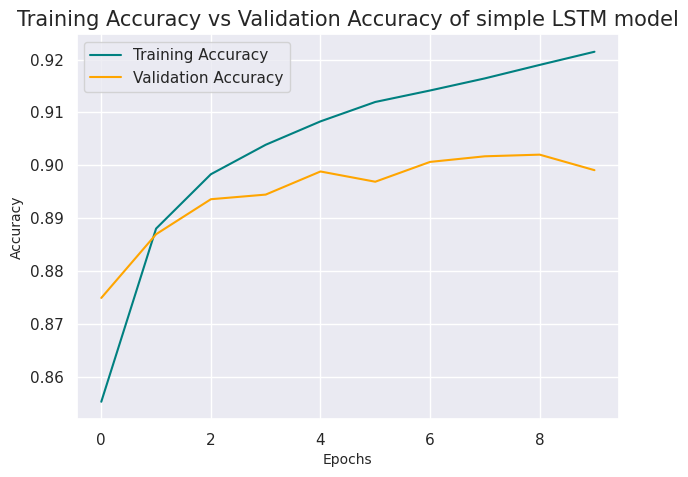

In [37]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy of simple LSTM model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

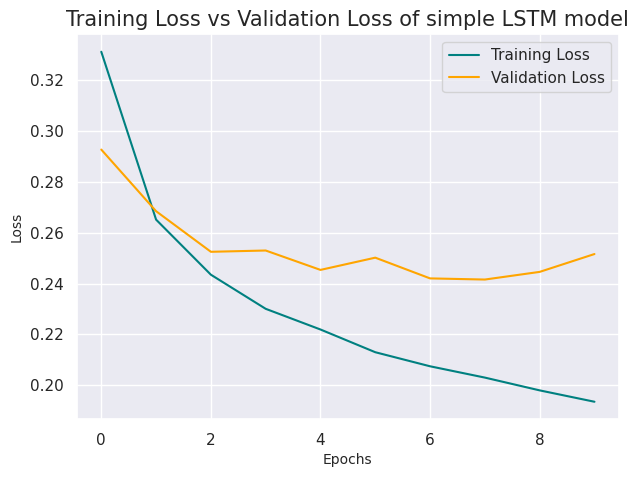

In [38]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss of simple LSTM model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [40]:
model.evaluate(X_test, y_test)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8988 - loss: 0.2466


[0.2502290904521942, 0.8977500200271606]

In [41]:
y_pred = model.predict(X_test)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [42]:
y_pred[0]

array([0.20288184], dtype=float32)

In [43]:
y_p = np.where(y_pred > 0.5, 1, 0)

In [44]:
y_p[0]

array([0])

In [45]:
y_pred[: 10]

array([[0.20288184],
       [0.7248791 ],
       [0.16341153],
       [0.9957072 ],
       [0.00252058],
       [0.00101352],
       [0.70583934],
       [0.17475194],
       [0.01906213],
       [0.00188527]], dtype=float32)

In [46]:
y_p[: 10]

array([[0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [47]:
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     20000
           1       0.91      0.88      0.90     20000

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



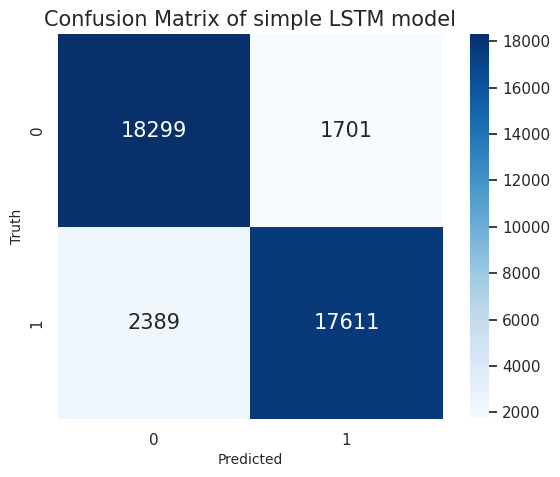

In [48]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test, y_p), annot = True, square = True, cbar = True, fmt = 'd', annot_kws = {'size': 15},
           cmap = 'Blues')
plt.title('Confusion Matrix of simple LSTM model', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()